In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# EDA

In [10]:
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

### Number of images with/without ships

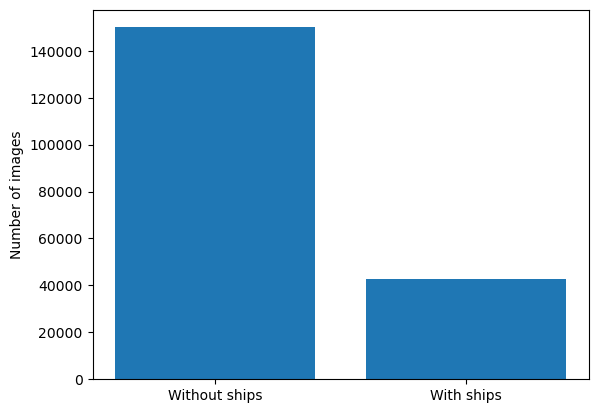

In [11]:
ships_by_img = df.groupby('ImageId').count().value_counts()
ships_by_img.index = [ind[0] for ind in ships_by_img.index]
plt.bar(["Without ships", "With ships"], [ships_by_img.iloc[0], ships_by_img.iloc[1:].sum()], width = 0.8)
plt.ylabel("Number of images");

### Distibution of number of images per ship count

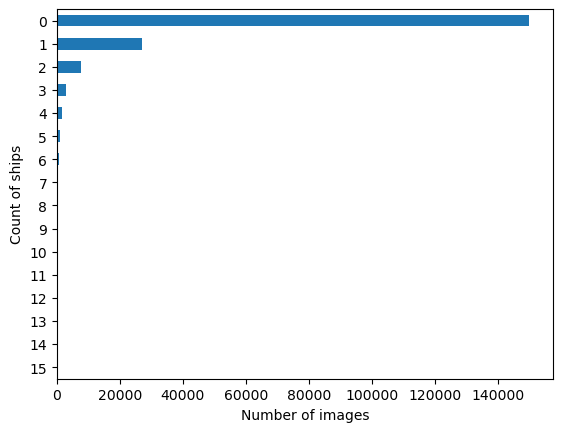

In [12]:
ships_by_img.sort_index(ascending=False, inplace=True)
ships_by_img.plot.barh()
plt.xlabel("Number of images")
plt.ylabel("Count of ships");

### Percentage of pixels - ships

In [13]:
def count_pixels_with_ships(s):
    """
    Arguments:
    s - string of Encoded Pixels
    Returns:
    pixels - amount of pixels that contain ship
    """
    if pd.isna(s):
        return 0
    array = np.asarray([int(x) for x in s.split()])
    pixels = sum(array[1::2])
    return pixels

In [14]:
df_pixels = df['EncodedPixels'].map(count_pixels_with_ships)
pixels_with_ships = sum(df_pixels)
all_pixels = len(df_pixels)*768*768
print(pixels_with_ships/all_pixels*100, "% of all pixels contain ship")
all_pixels_images_with_ships = len(df.loc[~df['EncodedPixels'].isna()]['ImageId'].unique()) * 768 * 768
print(pixels_with_ships/all_pixels_images_with_ships*100, "% of all pixels without shipless images contain ship")

0.09372023095241161 % of all pixels contain ship
0.5103189462587103 % of all pixels without shipless images contain ship


So $\approx$ 99.9% pixels do not contain ship so we cannot rely on accuracy because if our network marks all pixels as "no ship" then it will be 99.9% accurate but that network will be completely useless.  
That's why we should use some other metrics like IoU or Dice score.  
Also if we remove shipless images, still obly 0.5% of pixels are ships. So we have to work with a tiny objects on images

### Distribution of percentage of pixels - ships

Text(0.5, 0, '% of pixels - ships')

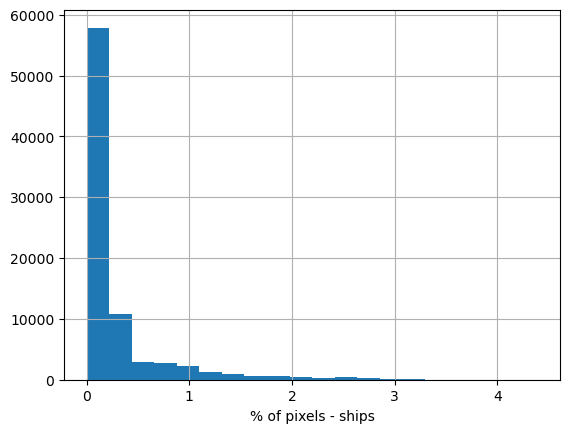

In [15]:
(df_pixels.loc[df_pixels > 0] / 768 / 768 * 100).hist(bins=20)
plt.xlabel('% of pixels - ships')

# Examples of images

In [16]:
def rle_to_mask(rle):
    """
    Converts Encoded Pixels to 1-channel image (mask)
    Args:
        rle: string of Encoded Pixels

    Returns:
        NumPy array representation of an image
    """
    img_shape = (768,768)
    if rle == '':
        return np.zeros((*img_shape, 1), dtype=np.float32)
    else:
        mask = np.zeros(img_shape[0] * img_shape[1], dtype=np.float32)
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[::2]
        lengths = array[1::2]

        current_position = 0
        for index, start in enumerate(starts):
            mask[int(start):int(start + lengths[index])] = 1
            current_position += lengths[index]
        return np.flipud(np.rot90(mask.reshape(*img_shape, 1), k=1))

In [17]:
df['EncodedPixels'] += ' '
df = df.groupby(['ImageId'], as_index=False).sum()
df['EncodedPixels'] = df['EncodedPixels'].replace(0, '')

df_with_ships = df.loc[~(df['EncodedPixels'] == '')]
df_without_ships = df.loc[df['EncodedPixels'] == '']

### Images with ships:

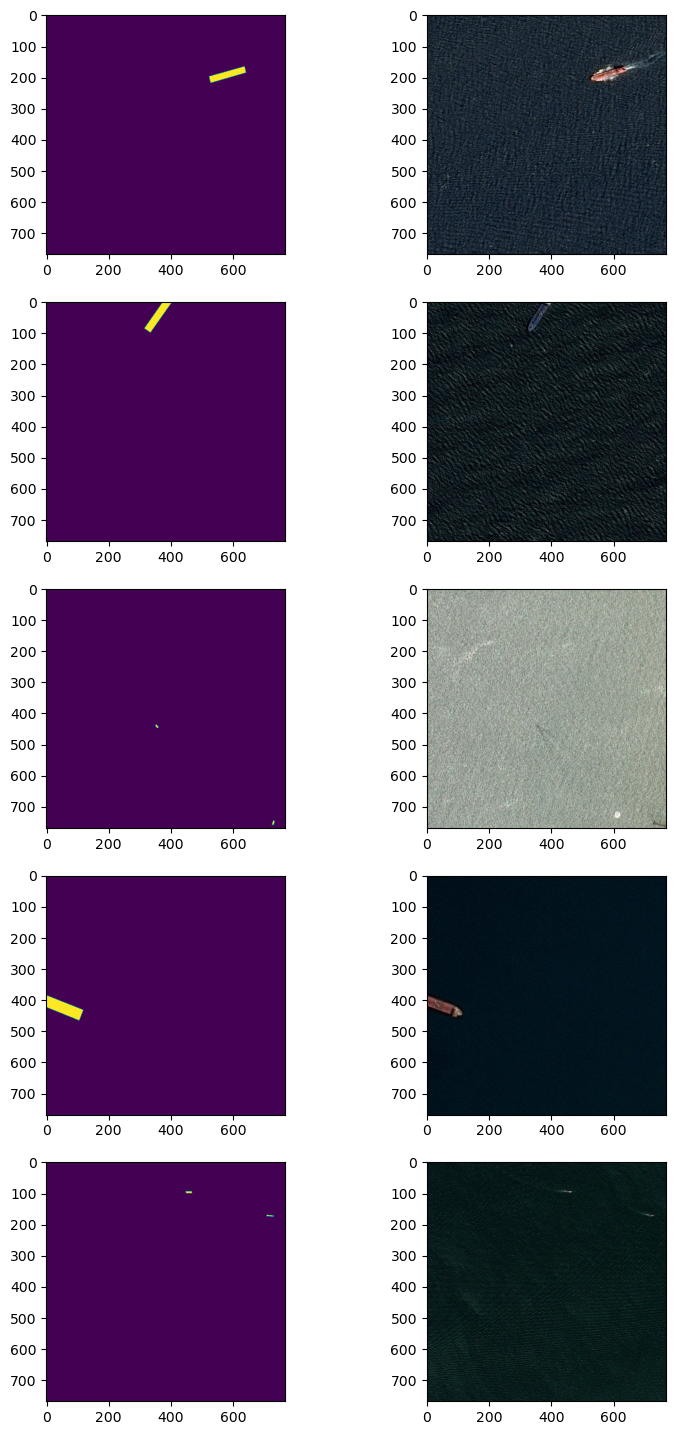

In [18]:
fig, axs = plt.subplots(5, 2, figsize=(9, 18))
i = 0
for ind, row in df_with_ships.sample(5).iterrows():
    axs[i, 0].imshow(rle_to_mask(row['EncodedPixels']))
    img = cv2.imread('/kaggle/input/airbus-ship-detection/train_v2/' + row['ImageId'])
    axs[i, 1].imshow(img[:,:,::-1])
    i += 1

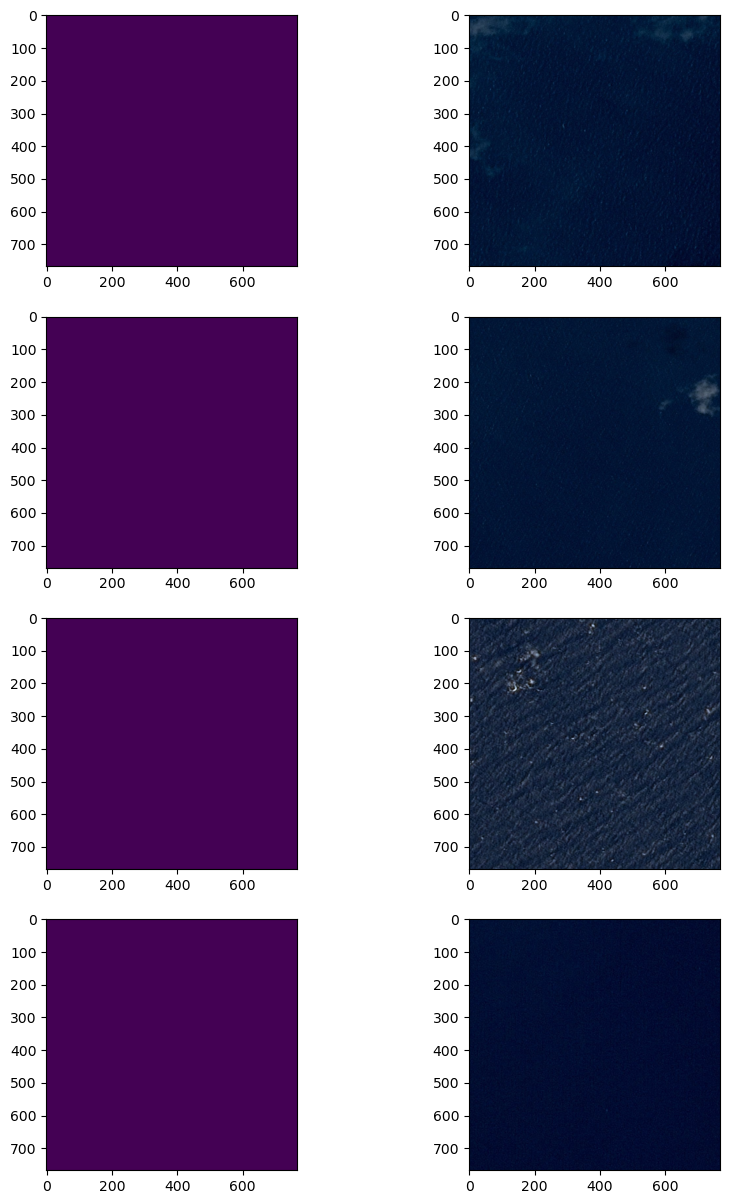

In [19]:
fig, axs = plt.subplots(4, 2, figsize=(10, 15))
i = 0
for ind, row in df_without_ships.sample(4).iterrows():
    axs[i, 0].imshow(rle_to_mask(row['EncodedPixels']))
    img = cv2.imread('/kaggle/input/airbus-ship-detection/train_v2/' + row['ImageId'])
    axs[i, 1].imshow(img[:,:,::-1])
    i += 1

### Generator for a dataset

In [20]:
def image_mask_gen():
    """
    Generator for a (image, mask) set item
    Reads image from images folder and converts it to a normalized tensor
    Gets Encoded Pixels for the corresponding image from csv file and converts it to a mask
    Warning: Make sure IMAGES_LIST is sorted the same way as the csv file
    """
    for i in images_range:
        img = tf.io.read_file(IMAGES_LIST[i])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (256, 256))
        img = tf.cast(img, tf.float32) / 255.  # Normalizing input
        mask = rle_to_mask(df['EncodedPixels'].iloc[i])
        mask = tf.image.resize(mask, (256, 256))
        yield (img, mask)

In [21]:
IMAGE_PATH = '/kaggle/input/airbus-ship-detection/train_v2/'
IMAGES_LIST = os.listdir(IMAGE_PATH)
IMAGES_LIST = sorted([IMAGE_PATH + i for i in IMAGES_LIST])

# DOWNSAMPLE IMAGES WITH NO SHIPS
images_range = [index for index in range(len(df)) if not (
        index % 3 and df['EncodedPixels'].iloc[index] == '')]  # Leaving approx 33% of images without ship

# Splitting data 70%/15%/15% training/validation/test sets
train_size = int(len(images_range) * 0.7)
val_size = int(len(images_range) * 0.15)

# Making a dataset
ds = tf.data.Dataset.from_generator(image_mask_gen,
                                    output_types=(tf.float32, tf.float32),
                                    output_shapes=((256, 256, 3), (256, 256, 1)))

train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size).skip(val_size)

### Model

In [22]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gamma=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(y_pred ** self.gamma) + tf.reduce_sum(y_true ** self.gamma) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result


def conv_block(inputs=None, n_filters=4, dropout_prob=0, max_pooling=True, batch_norm=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability (0 for no dropout)
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        batch_norm -- Whether to include BatchNormalization layers (after convolutional ones)
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = tf.keras.layers.Conv2D(n_filters,  # Number of filters
                                  kernel_size=(3, 3),  # Kernel size
                                  activation='relu',
                                  padding='same',
                                  kernel_initializer='he_normal')(inputs)
    if batch_norm:
        conv = tf.keras.layers.BatchNormalization()(conv)
    
    
    conv = tf.keras.layers.Conv2D(n_filters,  # Number of filters
                                  kernel_size=(3, 3),  # Kernel size
                                  activation='relu',
                                  padding='same',
                                  kernel_initializer='he_normal')(conv)
    # If batch_norm is True using a BatchNormalization layer
    if batch_norm:
        conv = tf.keras.layers.BatchNormalization()(conv)
    
    # If dropout_porb is not 0 using a Dropout layer
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = tf.keras.layers.MaxPool2D()(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection


def upsampling_block(prev_input, skipped_input, n_filters=4, dropout_prob=0, batch_norm=True):
    """
    Convolutional upsampling block

    Arguments:
        prev_input -- Input tensor from previous layer
        skipped_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability (0 for no dropout)
        batch_norm -- Whether to include BatchNormalization layers (after convolutional ones)
    Returns:
        conv -- Tensor output
    """

    up = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size=(3, 3),
                                         strides=(2, 2),
                                         padding='same')(prev_input)

    # Merge the previous output and the skipped_input
    merge = tf.keras.layers.concatenate([up, skipped_input], axis=3)

    conv = tf.keras.layers.Conv2D(n_filters, kernel_size=(3, 3),
                                  activation='relu', padding='same',
                                  kernel_initializer='he_normal')(merge)
    if batch_norm:
        conv = tf.keras.layers.BatchNormalization()(conv)
    
    conv = tf.keras.layers.Conv2D(n_filters, kernel_size=(3, 3),
                                  activation='relu', padding='same',
                                  kernel_initializer='he_normal')(conv)

    if batch_norm:
        conv = tf.keras.layers.BatchNormalization()(conv)
        
    if dropout_prob:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    
    return conv


def unet_model(input_size=(None, None, 3), n_filters=4, n_classes=1):
    """
    Unet model

    Arguments:
        input_size -- Input shape (None, None, 3) to allow arbitrary size
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = tf.keras.layers.Input(input_size)
    # Add some Gaussian Noise for regularization
    inputs = tf.keras.layers.GaussianNoise(0.05)(inputs)
    # Encoding
    cblock1 = conv_block(inputs, n_filters, dropout_prob=0)
    cblock2 = conv_block(cblock1[0], n_filters * 2, dropout_prob=0)
    cblock3 = conv_block(cblock2[0], n_filters * 4, dropout_prob=0)
    cblock4 = conv_block(cblock3[0], n_filters * 8, max_pooling=False, dropout_prob=0)

    # Decoding
    ublock6 = upsampling_block(cblock4[0], cblock3[1], n_filters * 4, dropout_prob=0)
    ublock7 = upsampling_block(ublock6, cblock2[1], n_filters * 2, dropout_prob=0)
    ublock8 = upsampling_block(ublock7, cblock1[1], n_filters)

    conv9 = tf.keras.layers.Conv2D(n_filters,
                                   (3, 3),
                                   activation='relu',
                                   padding='same',
                                   kernel_initializer='he_normal')(ublock8)

    # Output Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='sigmoid', padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

### Model summary

In [23]:
unet = unet_model()
optimizer = tf.keras.optimizers.Adam(0.0007)
unet.compile(optimizer=optimizer,
             loss=DiceLoss(),
             metrics=[tf.keras.metrics.BinaryIoU()])

unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   112         ['input_2[0][0]']                
                                4)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   16         ['conv2d[1][0]']                 
 alization)                     4)                                                            

In [24]:
EPOCHS = 10
BATCH_SIZE = 32

train_dataset = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.batch(BATCH_SIZE)
test_dataset = test_ds.batch(BATCH_SIZE)

print(train_ds.element_spec)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))


In [25]:
MCP = tf.keras.callbacks.ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
ES = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, verbose=0, restore_best_weights=True, patience=3, mode='max')
# Added EarlyStopping, ModelCheckpoint callbacks
model_history = unet.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=[MCP,ES])

Epoch 1/10
2023/2023 [==============================] - 2584s 1s/step - loss: 0.4825 - binary_io_u: 0.5691 - val_loss: 0.3934 - val_binary_io_u: 0.7050
Epoch 2/10
2023/2023 [==============================] - 2179s 1s/step - loss: 0.3595 - binary_io_u: 0.7201 - val_loss: 0.3441 - val_binary_io_u: 0.7257
Epoch 3/10
2023/2023 [==============================] - 2209s 1s/step - loss: 0.3158 - binary_io_u: 0.7432 - val_loss: 0.2970 - val_binary_io_u: 0.7513
Epoch 4/10
2023/2023 [==============================] - 2099s 1s/step - loss: 0.2880 - binary_io_u: 0.7596 - val_loss: 0.2975 - val_binary_io_u: 0.7526
Epoch 5/10
2023/2023 [==============================] - 2186s 1s/step - loss: 0.2701 - binary_io_u: 0.7705 - val_loss: 0.2693 - val_binary_io_u: 0.7717
Epoch 6/10
2023/2023 [==============================] - 2078s 1s/step - loss: 0.2561 - binary_io_u: 0.7793 - val_loss: 0.2660 - val_binary_io_u: 0.7734
Epoch 7/10
2023/2023 [==============================] - 2075s 1s/step - loss: 0.2442 - b

In [28]:
unet.save("trained_model")

In [29]:
unet.evaluate(test_dataset)

434/434 [==============================] - 1232s 493ms/step - loss: 0.2391 - binary_io_u: 0.7951


[0.23908492922782898, 0.7951196432113647]

# Result Analysis

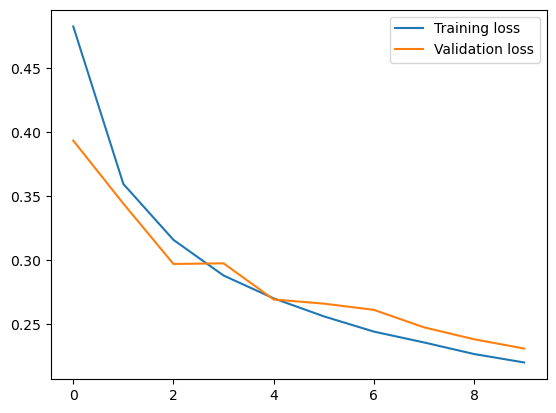

In [31]:
plt.plot(model_history.history['loss'], label='Training loss')
plt.plot(model_history.history['val_loss'], label='Validation loss')
plt.legend();

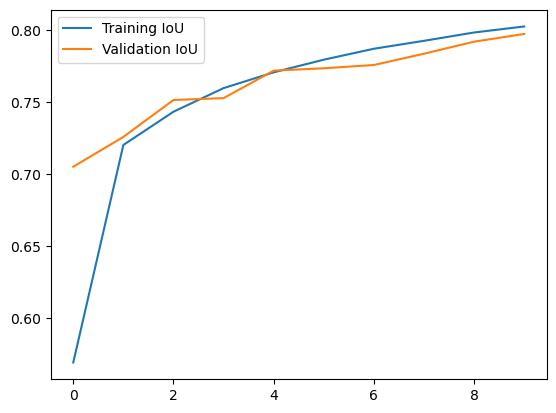

In [32]:
plt.plot(model_history.history['binary_io_u'], label='Training IoU')
plt.plot(model_history.history['val_binary_io_u'], label='Validation IoU')
plt.legend();

We got:
- Training set: 0.78 Dice and 0.8 IoU
- Validation set: 0.77 Dice and 0.8 IoU
- Test set: 0.76 Dice and 0.795 IoU  

A model does overfit a little bit, but it is not critical